In [1]:
# load needed modules
import numba 
import numpy as np

import time

import numpy as np
from numba import cuda
from math import ceil 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#print out gpu information

gpu = numba.cuda.get_current_device()
print("name = %s" % gpu.name)
print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("maxBlockDimX = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("maxBlockDimY = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("maxBlockDimZ = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("maxGridDimX = %s" % str(gpu.MAX_GRID_DIM_X))
print("maxGridDimY = %s" % str(gpu.MAX_GRID_DIM_Y))
print("maxGridDimZ = %s" % str(gpu.MAX_GRID_DIM_Z))
print("maxSharedMemoryPerBlock = %s" % str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("asyncEngineCount = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("canMapHostMemory = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("multiProcessorCount = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("warpSize = %s" % str(gpu.WARP_SIZE))
print("unifiedAddressing = %s" % str(gpu.UNIFIED_ADDRESSING))
print("pciBusID = %s" % str(gpu.PCI_BUS_ID))
print("pciDeviceID = %s" % str(gpu.PCI_DEVICE_ID))

name = b'Tesla K80'
maxThreadsPerBlock = 1024
maxBlockDimX = 1024
maxBlockDimY = 1024
maxBlockDimZ = 64
maxGridDimX = 2147483647
maxGridDimY = 65535
maxGridDimZ = 65535
maxSharedMemoryPerBlock = 49152
asyncEngineCount = 2
canMapHostMemory = 1
multiProcessorCount = 13
warpSize = 32
unifiedAddressing = 1
pciBusID = 4
pciDeviceID = 0


In [3]:
#generate dummy data for test

Nz, Ny, Nx = 128, 512, 128

real_data = (np.ones((Nz, Ny, Nx)) * np.sin(np.linspace(0, 20, Ny)[np.newaxis, :, np.newaxis])*0.5 
             + np.random.normal(scale=1.0, size=(Nz, Ny, Nx)) )

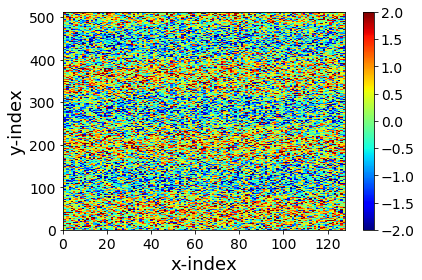

In [4]:
#visulize date: before filtering:

plt.pcolormesh(real_data[Nz//2,:, :], vmin=-2, vmax=2, cmap=plt.cm.jet)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.xlabel("x-index", fontsize=18)
plt.xticks( fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks( fontsize=14)

plt.tight_layout()

plt.show()

In [5]:
#cpu version: function

@numba.njit
def numba_median(array):
    return np.median(array)

@numba.njit
def cpu_smooth_kernel(input_data, output_data, fkt, stencil):
    # data size
    Nz, Ny, Nx = np.shape(input_data)
    # stencil size
    dx = stencil[0]
    dy = stencil[1]
    dz = stencil[2]
    # run over all data
    for z_id in range(Nz):
        z_min = max(z_id-dz, 0)
        z_max = min(z_id+dz+1, Nz)
        for y_id in range(Ny):
            y_min = max(y_id-dy, 0)
            y_max = min(y_id+dy+1, Ny)
            for x_id in range(Nx):
                x_min = max(x_id-dx, 0)
                x_max = min(x_id+dx+1, Nx)

                output_data[z_id, y_id, x_id] = fkt(input_data[z_min:z_max, y_min:y_max, x_min:x_max])

In [6]:
# define the output result: same size of input data
output_data = real_data.copy()

#define the stencil size (3D)
stencil = (8, 6, 8)

In [7]:
#calculate the runtime of cpu version

start = time.time()
cpu_smooth_kernel(real_data, output_data, numba_median, stencil)
end = time.time()
print("Elapsed (cpu with compilation) = %s" % (end - start))

start = time.time()
cpu_smooth_kernel(real_data, output_data, numba_median, stencil)
end = time.time()
print("Elapsed (cpu without compilation) = %s" % (end - start))

# cpu baseline:
# Elapsed (cpu with compilation) = 406.972208738327
# Elapsed (cpu without compilation) = 406.972208738327

Elapsed (cpu with compilation) = 406.972208738327
Elapsed (cpu without compilation) = 412.3802390098572
